In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch import nn
import torch
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from LSTMFeature import LSTMFeatureExtractor

In [18]:
# Đặt lookback length T = 96 như trong bài báo
FIXED_LOOKBACK_LENGTH = 96
# Các độ dài dự báo S như trong bài báo
PREDICTION_LENGTHS = [96, 192, 336, 720]

In [19]:
# --- 1. Tải và Tiền xử lý Dữ liệu ---
print("--- 1. Tải và Tiền xử lý Dữ liệu ---")
df = pd.read_csv("../dataset/ECL.csv")
original_df = df.copy()

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Điền khuyết bằng nội suy theo thời gian
print("Điền khuyết bằng nội suy theo thời gian...")
df = df.interpolate(method='time')

# Chuẩn hóa dữ liệu
print("Chuẩn hóa dữ liệu...")
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
print("Tiền xử lý hoàn tất.")


--- 1. Tải và Tiền xử lý Dữ liệu ---
Điền khuyết bằng nội suy theo thời gian...
Chuẩn hóa dữ liệu...
Tiền xử lý hoàn tất.



--- 2. Lựa chọn Đặc trưng ---
Đã chọn 50 đặc trưng có tương quan cao nhất với 'MT_001'.
Vẽ ma trận tương quan của 50 đặc trưng và MT_001...


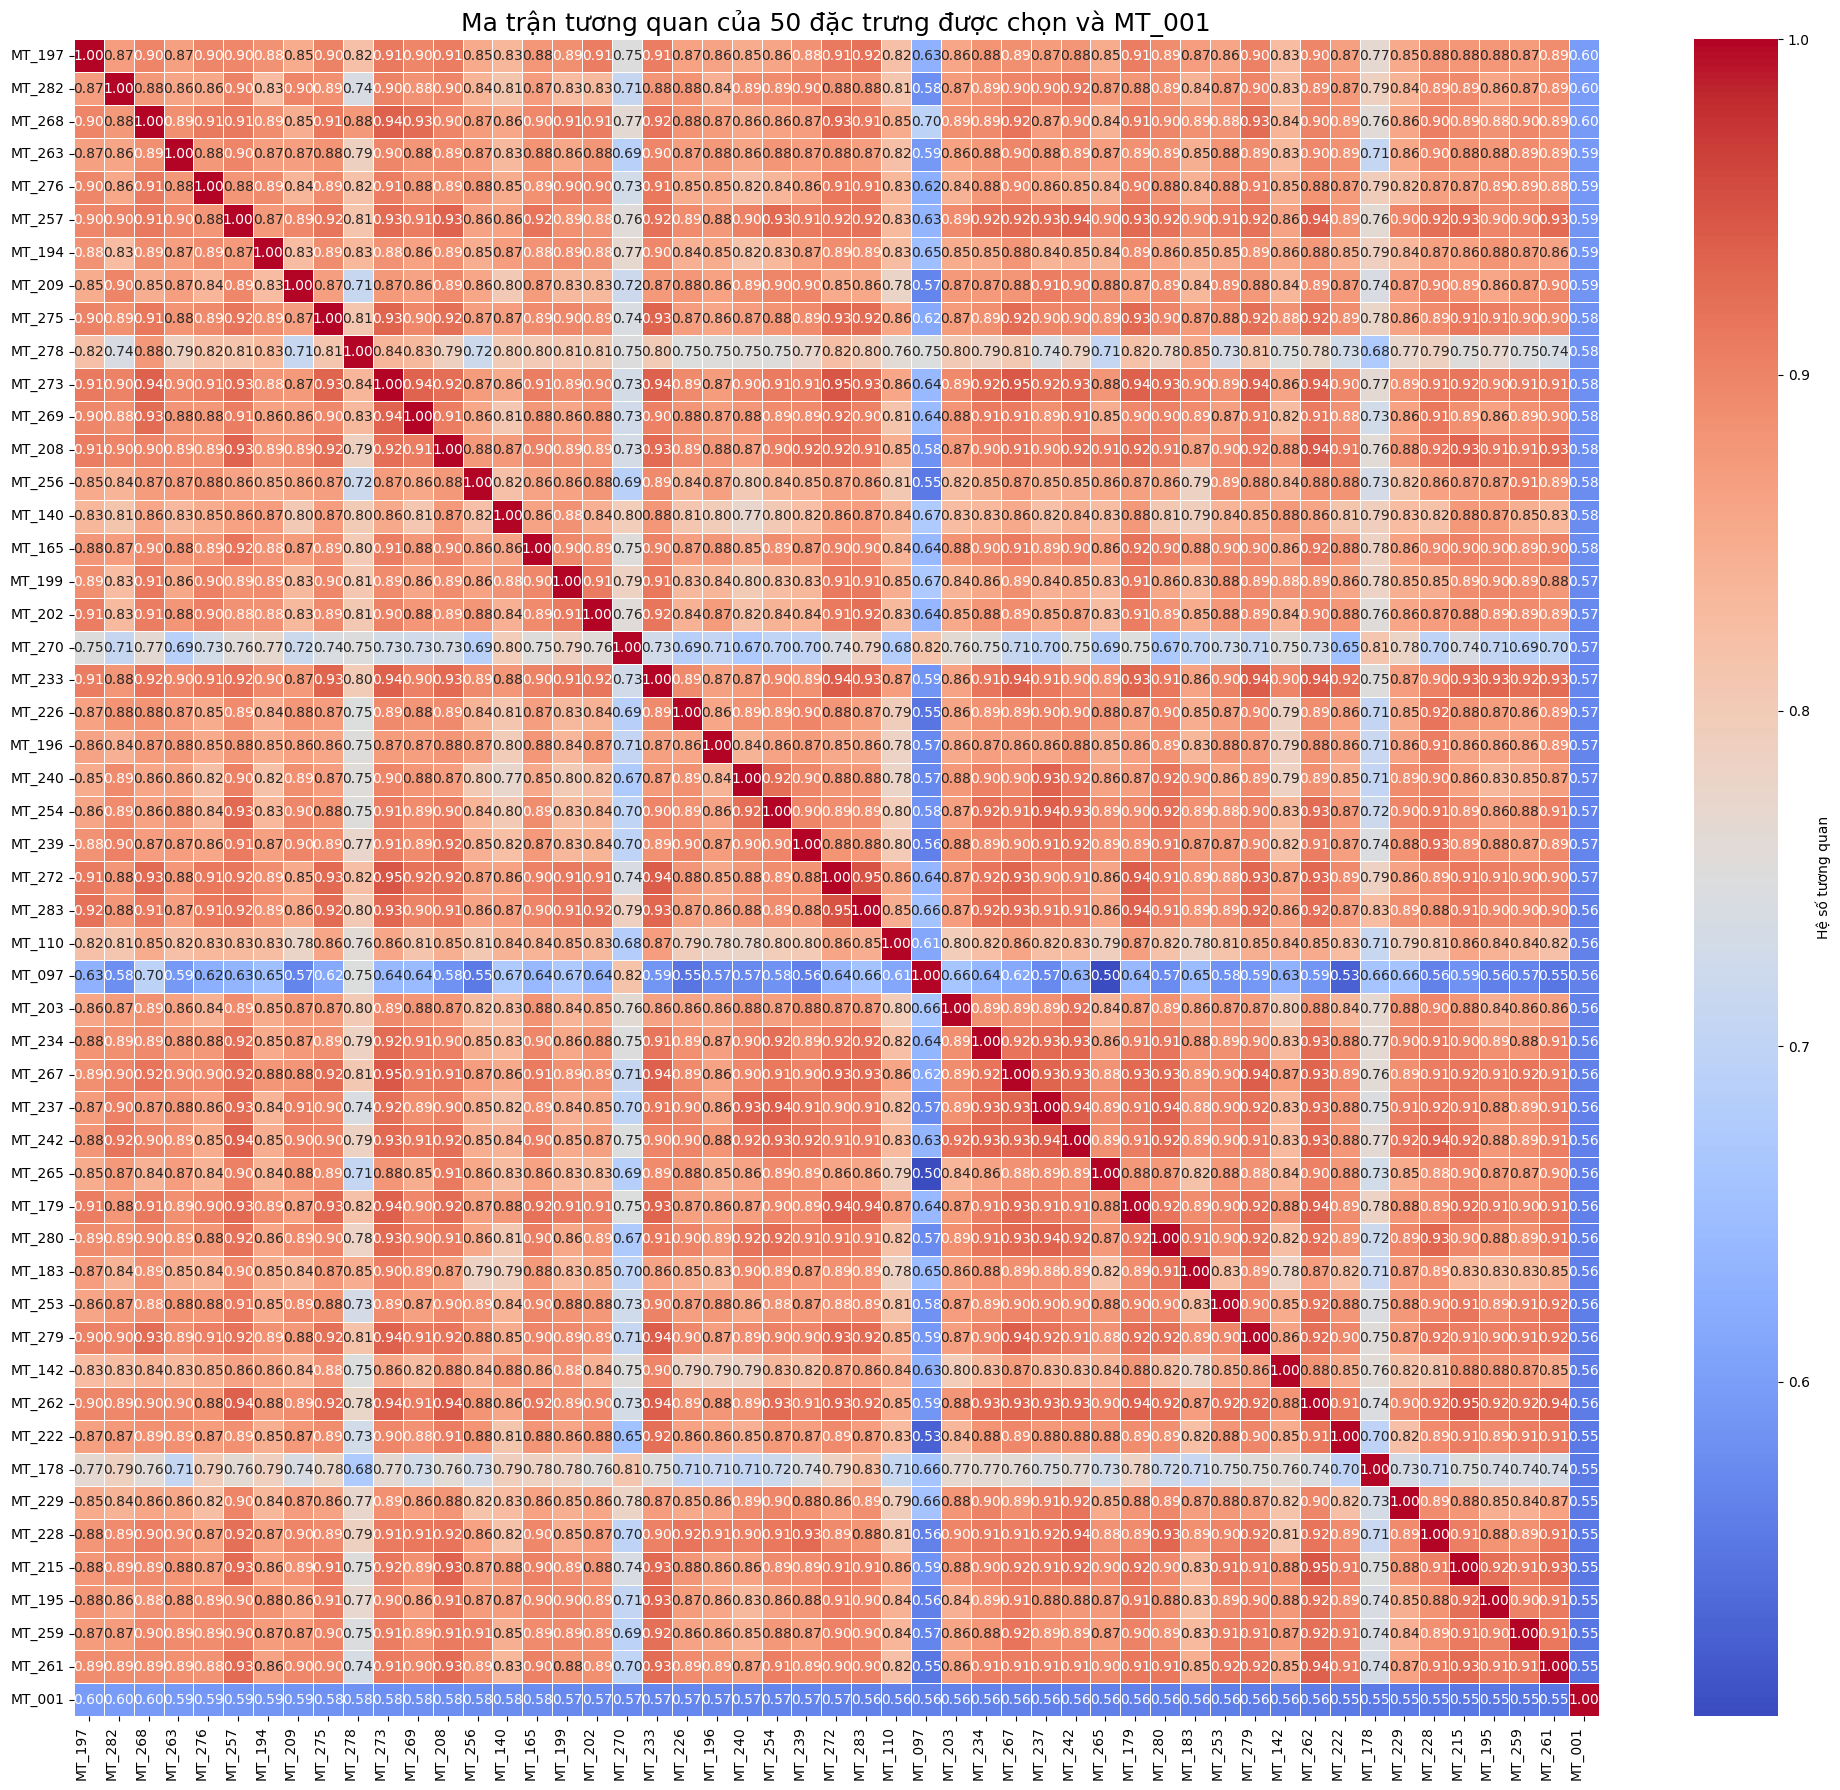

Đã vẽ ma trận tương quan.


In [20]:
# --- 2. Lựa chọn Đặc trưng ---
print("\n--- 2. Lựa chọn Đặc trưng ---")
correlations = df.corr()['MT_001'].abs().sort_values(ascending=False)
top_50_correlations = correlations.drop('MT_001').head(50)
top_features = top_50_correlations.index.tolist()
selected_columns = top_features + ['MT_001']
reduced_df = scaled_df[selected_columns].astype(np.float32)
print(f"Đã chọn {len(selected_columns) - 1} đặc trưng có tương quan cao nhất với 'MT_001'.")

# --- Vẽ Ma trận tương quan (không thay đổi) ---
print("Vẽ ma trận tương quan của 50 đặc trưng và MT_001...")
correlation_matrix_df = df[selected_columns] # Lấy DataFrame con từ df đã xử lý (chưa chuẩn hóa)

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix_df.corr(),
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            cbar_kws={'label': 'Hệ số tương quan'})
plt.title('Ma trận tương quan của 50 đặc trưng được chọn và MT_001', fontsize=18)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()
print("Đã vẽ ma trận tương quan.")


In [21]:
# --- 3. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo một bước) ---
# Dùng FIXED_LOOKBACK_LENGTH = 96
print(f"\n--- 3. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo một bước) với lookback T={FIXED_LOOKBACK_LENGTH} ---")
def create_supervised_data(data, target_column='MT_001', window_size=FIXED_LOOKBACK_LENGTH):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

X_single_step, y_single_step = create_supervised_data(reduced_df, window_size=FIXED_LOOKBACK_LENGTH)

print("Shape of X (dự báo một bước):", X_single_step.shape)
print("Shape of y (dự báo một bước):", y_single_step.shape)



--- 3. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo một bước) với lookback T=96 ---
Shape of X (dự báo một bước): (26208, 96, 51)
Shape of y (dự báo một bước): (26208,)


In [22]:
# --- 4. Trích xuất Đặc trưng bằng LSTM ---
print("\n--- 4. Trích xuất Đặc trưng bằng LSTM ---")
lstm_extractor = LSTMFeatureExtractor(input_size=X_single_step.shape[2])
lstm_extractor.eval()

with torch.no_grad():
    features_single_step = lstm_extractor(torch.tensor(X_single_step, dtype=torch.float32)).numpy()
print("Đặc trưng LSTM cho dự báo một bước đã được trích xuất.")
print("Shape of features (dự báo một bước):", features_single_step.shape)



--- 4. Trích xuất Đặc trưng bằng LSTM ---
Đặc trưng LSTM cho dự báo một bước đã được trích xuất.
Shape of features (dự báo một bước): (26208, 64)


In [23]:
# --- 5. Huấn luyện và Đánh giá XGBoost (Dự báo một bước) trên toàn bộ dữ liệu ---
print("\n--- 5. Huấn luyện và Đánh giá XGBoost (Dự báo một bước) trên toàn bộ dữ liệu ---")
xgb_model_single_step = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.01, random_state=42)
xgb_model_single_step.fit(features_single_step, y_single_step)
print("Mô hình XGBoost (dự báo một bước) đã được huấn luyện trên toàn bộ dữ liệu.")



--- 5. Huấn luyện và Đánh giá XGBoost (Dự báo một bước) trên toàn bộ dữ liệu ---
Mô hình XGBoost (dự báo một bước) đã được huấn luyện trên toàn bộ dữ liệu.


In [24]:
y_pred_single_step_scaled = xgb_model_single_step.predict(features_single_step)
mse_single_step_scaled = mean_squared_error(y_single_step, y_pred_single_step_scaled)
mae_single_step_scaled = mean_absolute_error(y_single_step, y_pred_single_step_scaled)

print(f"MSE (Dự báo một bước, dữ liệu CHUẨN HÓA): {mse_single_step_scaled:.4f}")
print(f"MAE (Dự báo một bước, dữ liệu CHUẨN HÓA): {mae_single_step_scaled:.4f}")


MSE (Dự báo một bước, dữ liệu CHUẨN HÓA): 0.4588
MAE (Dự báo một bước, dữ liệu CHUẨN HÓA): 0.5011


In [25]:
# --- Đảo ngược chuẩn hóa cho kết quả dự báo một bước ---
print("\n--- Đảo ngược chuẩn hóa cho kết quả dự báo một bước ---")
mt_001_col_idx = scaled_df.columns.get_loc('MT_001')
dummy_array_for_inverse = np.zeros((y_pred_single_step_scaled.shape[0], scaled_df.shape[1]))
dummy_array_for_inverse[:, mt_001_col_idx] = y_pred_single_step_scaled
y_pred_single_step_inverted = scaler.inverse_transform(dummy_array_for_inverse)[:, mt_001_col_idx]

original_y_single_step = df['MT_001'].iloc[X_single_step.shape[1]:].values
original_y_single_step = original_y_single_step[:y_pred_single_step_inverted.shape[0]]

mse_single_step_inverted = mean_squared_error(original_y_single_step, y_pred_single_step_inverted)
mae_single_step_inverted = mean_absolute_error(original_y_single_step, y_pred_single_step_inverted)

print(f"MSE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): {mse_single_step_inverted:.4f}")
print(f"MAE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): {mae_single_step_inverted:.4f}")



--- Đảo ngược chuẩn hóa cho kết quả dự báo một bước ---
MSE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): 299.5355
MAE (Dự báo một bước, dữ liệu GỐC sau đảo ngược chuẩn hóa): 12.8052



--- 8. Vẽ sơ đồ so sánh dữ liệu thực và dự báo (Dự báo một bước) ---


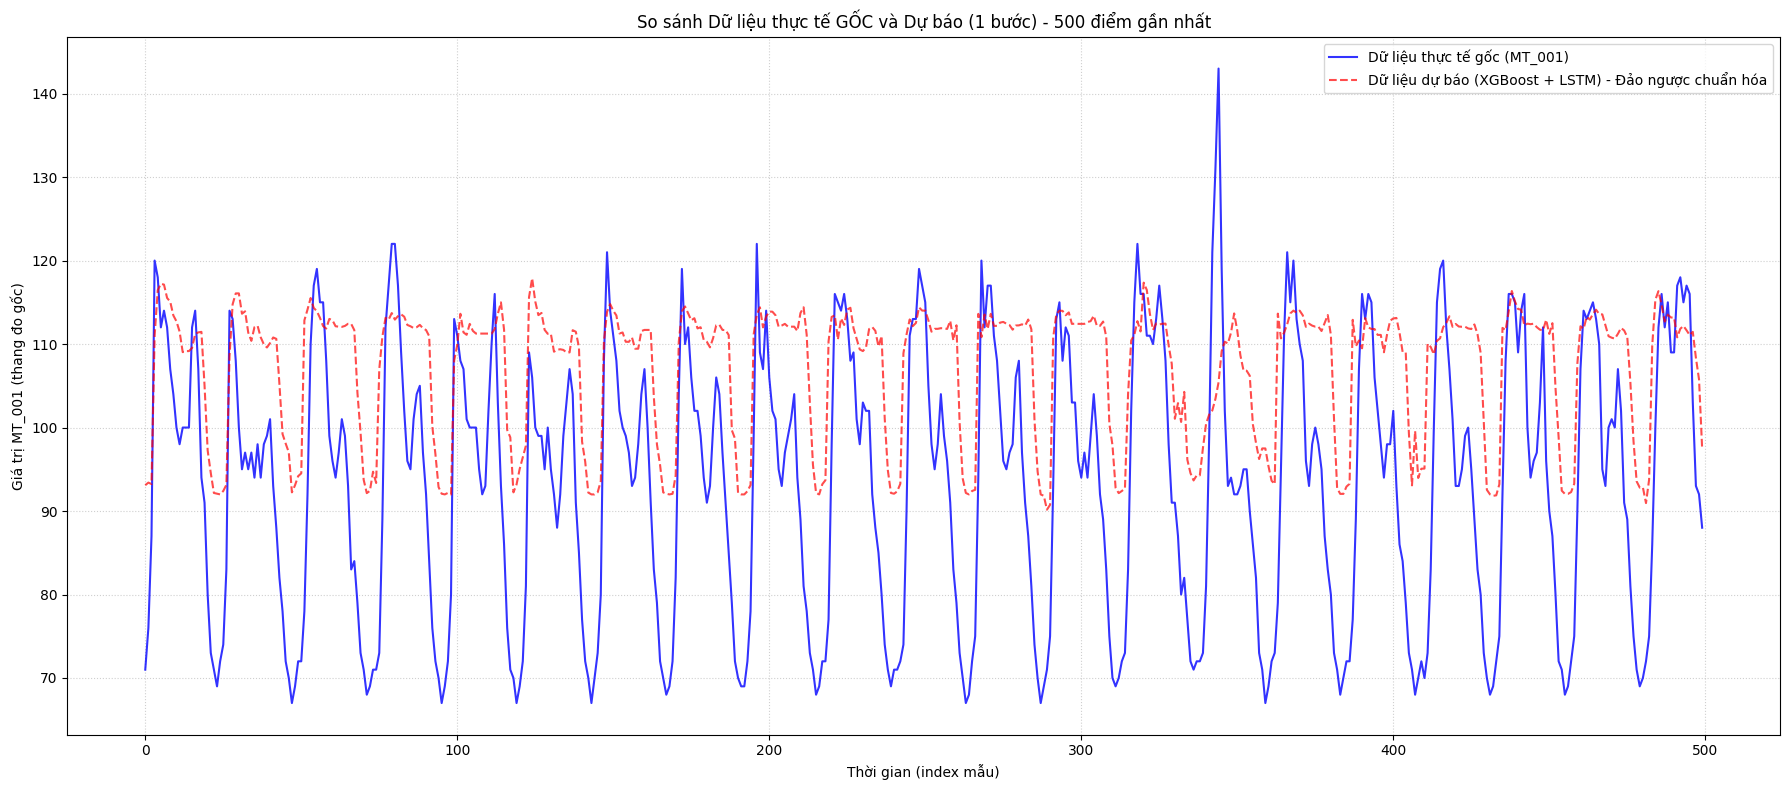

Đã vẽ biểu đồ so sánh dữ liệu thực tế gốc và dự báo sau đảo ngược chuẩn hóa.


In [26]:
# --- 8. Vẽ sơ đồ so sánh dữ liệu thực và dự báo (Dự báo một bước sau đảo ngược chuẩn hóa) ---
print("\n--- 8. Vẽ sơ đồ so sánh dữ liệu thực và dự báo (Dự báo một bước) ---")
num_points_to_plot = 500

plt.figure(figsize=(18, 8))
plt.plot(original_y_single_step[-num_points_to_plot:], label='Dữ liệu thực tế gốc (MT_001)', color='blue', alpha=0.8)
plt.plot(y_pred_single_step_inverted[-num_points_to_plot:], label='Dữ liệu dự báo (XGBoost + LSTM) - Đảo ngược chuẩn hóa', color='red', linestyle='--', alpha=0.7)
plt.title(f'So sánh Dữ liệu thực tế GỐC và Dự báo (1 bước) - {num_points_to_plot} điểm gần nhất')
plt.xlabel('Thời gian (index mẫu)')
plt.ylabel('Giá trị MT_001 (thang đo gốc)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()
print("Đã vẽ biểu đồ so sánh dữ liệu thực tế gốc và dự báo sau đảo ngược chuẩn hóa.")


In [27]:
# --- 6. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo đa bước) ---
# Dùng FIXED_LOOKBACK_LENGTH = 96 và PREDICTION_LENGTHS
print(f"\n--- 6. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo đa bước) với lookback T={FIXED_LOOKBACK_LENGTH} ---")
def create_multistep_supervised_data(data, target_column='MT_001', window_size=FIXED_LOOKBACK_LENGTH, horizon=12):
    X, y = [], []
    target_series = data[target_column].values
    for i in range(window_size, len(data) - horizon):
        X.append(data.iloc[i-window_size:i].values)
        y.append(target_series[i:i+horizon])
    return np.array(X), np.array(y)

# Tạo dữ liệu cho từng horizon từ PREDICTION_LENGTHS
multi_step_data = {}
for h in PREDICTION_LENGTHS:
    X_h, y_h = create_multistep_supervised_data(reduced_df, window_size=FIXED_LOOKBACK_LENGTH, horizon=h)
    multi_step_data[h] = {'X': X_h, 'y': y_h}
    print(f"Shape of X_{h}: {X_h.shape}, y_{h}: {y_h.shape}")



--- 6. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo đa bước) với lookback T=96 ---
Shape of X_96: (26112, 96, 51), y_96: (26112, 96)
Shape of X_192: (26016, 96, 51), y_192: (26016, 192)
Shape of X_336: (25872, 96, 51), y_336: (25872, 336)
Shape of X_720: (25488, 96, 51), y_720: (25488, 720)


In [28]:
# --- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost cho Dự báo Đa bước trên toàn bộ dữ liệu ---
print("\n--- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost cho Dự báo Đa bước trên toàn bộ dữ liệu ---")

def extract_lstm_features(X, input_size, model=None):
    if model is None:
        model = LSTMFeatureExtractor(input_size)
    model.eval()
    with torch.no_grad():
        return model(torch.tensor(X, dtype=torch.float32)).numpy()

# Huấn luyện và đánh giá cho từng horizon
all_mse_multi_step = []
all_mae_multi_step = []

print("\n--- Kết quả Đánh giá Dự báo Đa Bước (trên toàn bộ dữ liệu CHUẨN HÓA) ---")
for h in PREDICTION_LENGTHS:
    X_h = multi_step_data[h]['X']
    y_h = multi_step_data[h]['y']

    features_h = extract_lstm_features(X_h, input_size=X_h.shape[2], model=lstm_extractor)

    model_h = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
    model_h.fit(features_h, y_h)
    y_pred_h = model_h.predict(features_h)

    mse_h = mean_squared_error(y_h, y_pred_h)
    mae_h = mean_absolute_error(y_h, y_pred_h)

    all_mse_multi_step.append(mse_h)
    all_mae_multi_step.append(mae_h)

    print(f"Horizon {h:2d} - MSE: {mse_h:.4f}, MAE: {mae_h:.4f}")

# Tính trung bình các kết quả từ tất cả các prediction lengths (như trong bài báo)
avg_mse_multi_step = np.mean(all_mse_multi_step)
avg_mae_multi_step = np.mean(all_mae_multi_step)

print(f"\n--- KẾT QUẢ TRUNG BÌNH TỪ TẤT CẢ CÁC ĐỘ DÀI DỰ BÁO (CHUẨN HÓA) ---")
print(f"Average MSE across horizons: {avg_mse_multi_step:.4f}")
print(f"Average MAE across horizons: {avg_mae_multi_step:.4f}")

print("\nQuá trình hoàn tất.")


--- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost cho Dự báo Đa bước trên toàn bộ dữ liệu ---

--- Kết quả Đánh giá Dự báo Đa Bước (trên toàn bộ dữ liệu CHUẨN HÓA) ---
Horizon 96 - MSE: 0.2843, MAE: 0.3665
Horizon 192 - MSE: 0.2940, MAE: 0.3721
Horizon 336 - MSE: 0.3009, MAE: 0.3776
Horizon 720 - MSE: 0.3142, MAE: 0.3891

--- KẾT QUẢ TRUNG BÌNH TỪ TẤT CẢ CÁC ĐỘ DÀI DỰ BÁO (CHUẨN HÓA) ---
Average MSE across horizons: 0.2984
Average MAE across horizons: 0.3763

Quá trình hoàn tất.
